<a href="https://colab.research.google.com/github/vedantdesai13/NLP/blob/master/GANS_endsem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from IPython import display

# from utils import Logger

import torch
import matplotlib.pyplot as plt

import numpy as np
from torch import nn
from torch.optim import Adam
from torch.autograd import Variable
from torchvision import transforms, datasets

In [0]:
transform = transforms.Compose([            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5,), (.5,))
                              ])
trainset = datasets.MNIST('MNIST_train', download=True, train=True, transform=transform)
valset = datasets.MNIST('MNIST_test', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [0]:
class DiscriminativeNet(torch.nn.Module):
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 16),
            # nn.Sigmoid(),
        )
        self.sigmoid = nn.Sigmoid()


    def forward(self, x, z):
        # Convolutional layers
        # print(x.shape)
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = self.conv4(x)
        # print(x.shape)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        # print(x.shape)
        x = self.out(x)
        # print(x.shape)
        x = DTD(x, z)

        # x = self.sigmoid(x)
        # print(x.shape)
        return x

def DTD(data, z):
    # l=[]
    # for x in data:
    #     e = 0
    #     for t in x:
    #         e+=torch.exp(t)
    #     l.append(e/(e+1))
    if z==0:
        ans = torch.div(torch.sum(torch.exp(data), axis=1),(torch.sum(torch.exp(data), axis=1)+1))
    else:
        ans = 1-torch.div(torch.sum(torch.exp(data), axis=1),(torch.sum(torch.exp(data), axis=1)+1))
    # print(type(l[0]),l[0])
    # r = Variable(torch.Tensor(l), requires_grad = True)
    # print(ans.size())
    ans = torch.reshape(ans, (ans.size(0), 1))
    # print(ans.size())
    # print(r)
    return ans.cuda()

In [0]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        # print(x.shape)
        x = self.linear(x)
        # print(x.shape)
        x = x.view(x.shape[0], 1024, 4, 4)
        # print(x.shape)
        # Convolutional layers
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
            
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100), requires_grad = True)
    if torch.cuda.is_available(): return n.cuda()
    return n

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [0]:
# Create Network instances and init weights
generator = GenerativeNet()
generator.apply(init_weights)

discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available
if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

In [0]:
d_optimizer = Adam(discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))
g_optimizer = Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 200

In [0]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [0]:
# def train_discriminator(optimizer, real_data, fake_data):   
#     # Reset gradients
#     optimizer.zero_grad()
    
#     # 1. Train on Real Data
#     # for param in discriminator.parameters():
#     #     param.requires_grad = True
#     prediction_real = discriminator(real_data)
#     # Calculate error and backpropagate
#     # print(real_data_target(real_data.size(0))[0], prediction_real)
#     print(prediction_real[0].grad, real_data_target(real_data.size(0))[0].grad)

#     error_real = loss(prediction_real, real_data_target(real_data.size(0)))
#     # error_real = Variable(error_real, requires_grad = False)
#     # print(error_real)
#     error_real.backward(retain_graph=True)

#     # 2. Train on Fake Data
#     prediction_fake = discriminator(fake_data)
#     # Calculate error and backpropagate
#     error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
#     error_fake = Variable(error_fake, requires_grad = True)
#     error_fake.backward()
    
#     # Update weights with gradients
#     optimizer.step()
    
#     return error_real + error_fake, prediction_real, prediction_fake
#     return (0, 0, 0)

# def train_generator(optimizer, fake_data):
#     # Reset gradients
#     optimizer.zero_grad()
#     # Sample noise and generate fake data
#     prediction = discriminator(fake_data)
#     # Calculate error and backpropagate
#     error = loss(prediction, real_data_target(prediction.size(0)))
#     error = Variable(error, requires_grad = True)
#     error.backward()
#     # Update weights with gradients
#     optimizer.step()
#     # Return error
#     return error

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # 1. Train on Real Data
    prediction_real = discriminator(real_data, 0).detach()
    # Calculate error and backpropagate
    # print("Real = ",prediction_real)
    prediction_real = Variable(prediction_real, requires_grad = True)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 2. Train on Fake Data
    prediction_fake = discriminator(fake_data, 1).detach()
    # print("Fake = ",prediction_fake)
    # Calculate error and backpropagate
    prediction_fake = Variable(prediction_fake, requires_grad = True)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake
    return (0, 0, 0)

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data, 1)
    # Calculate error and backpropagate
    # print(prediction)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
num_test_samples = 1
test_noise = noise(num_test_samples)

0 0 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


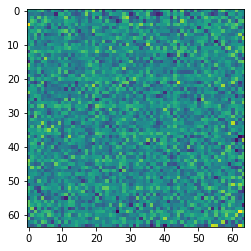

0 25 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 50 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 75 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 100 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 125 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 150 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 175 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 200 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7181, de

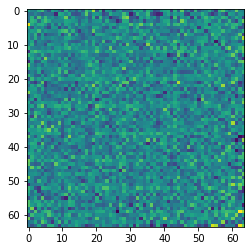

0 225 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 250 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 275 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 300 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 325 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 350 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 375 tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 400 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7179,

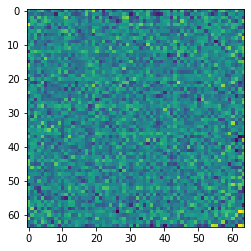

0 425 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 450 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 475 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 500 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 525 tensor(0.1289, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 550 tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
0 575 tensor(0.1290, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.7177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [0]:
for epoch in range(num_epochs):
    
    for n_batch, (real_batch,_) in enumerate(trainloader):
        
        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()

        # Train D
        # print(real_data.size(), fake_data.size())
        # fake_data = Variable(fake_data)
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        # logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 25 == 0:
            # display.clear_output(True)
            # Display Images
            print(epoch, n_batch,d_error, g_error)
        if (n_batch) % 200 == 0:
            test_images = generator(test_noise).data.cpu()
            plt.imshow(test_images[0].numpy().squeeze());
            plt.show()

In [217]:
triple_data = [[] for i in range(10)]

for x,y in trainloader:
    for i in range(len(y)):
        if len(triple_data[y[i]])<10:
            triple_data[y[i]].append(x[i])
    
    c=0
    for t in triple_data:
        print(len(t))
        if len(t)<10:
            c=1
            # print(len(t))
    
    if c==1:
        continue
    else:
        break

3
7
6
9
2
6
9
7
6
9
6
10
10
10
8
10
10
10
8
10
10
10
10
10
10
10
10
10
10
10


0.9999993


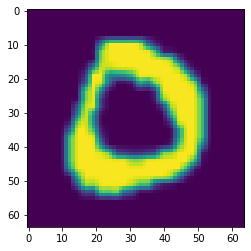

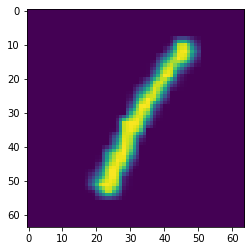

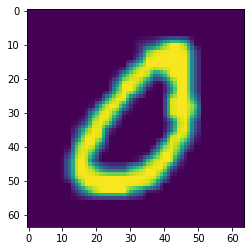

0.99999976


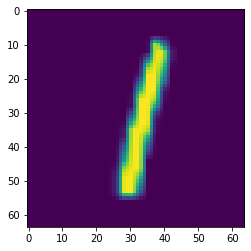

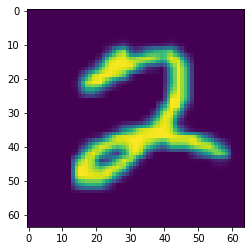

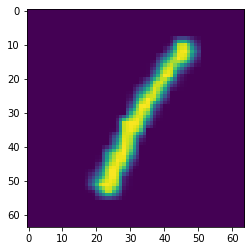

0.8740856


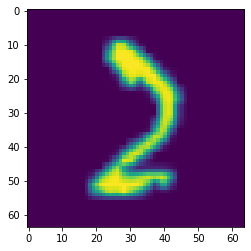

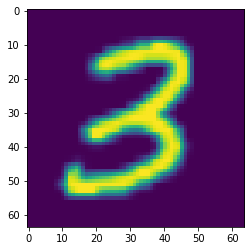

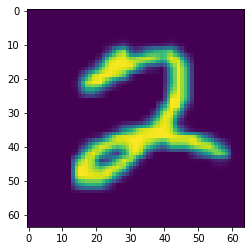

1.0


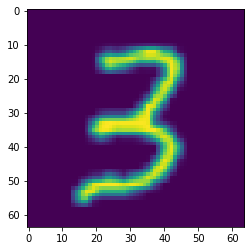

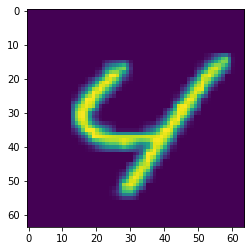

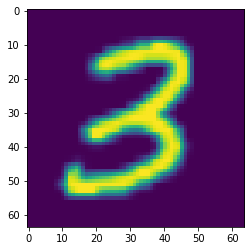

0.92668873


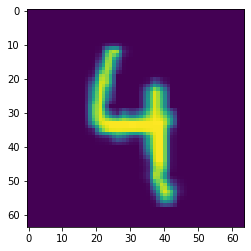

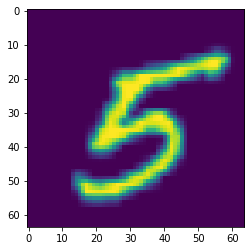

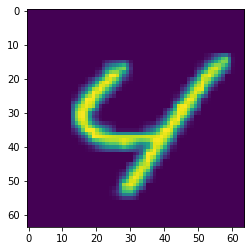

0.01546481


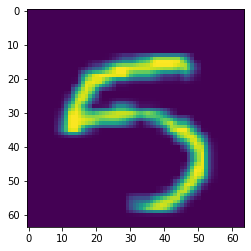

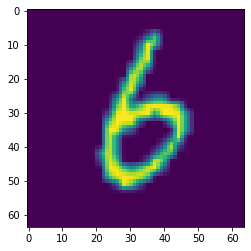

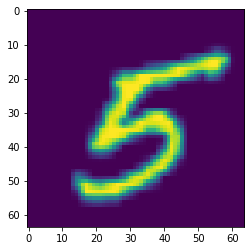

0.32370988


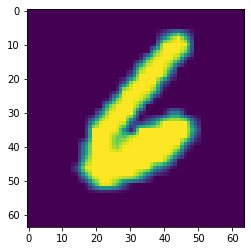

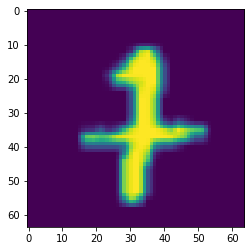

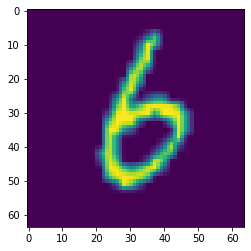

0.9894186


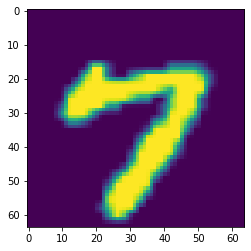

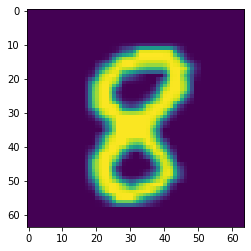

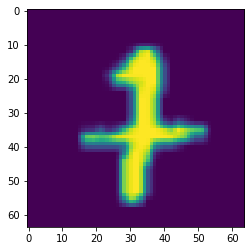

0.9094811


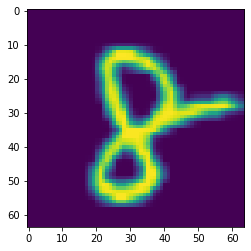

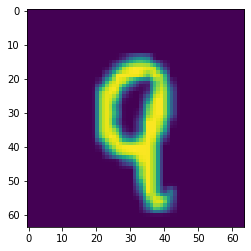

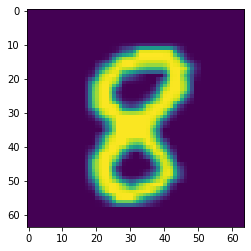

In [248]:
from scipy.spatial import distance
for i in range(len(triple_data)-1):
    a = np.exp(np.linalg.norm(triple_data[i][0]-triple_data[i+1][5]))
    b = np.exp(np.linalg.norm(triple_data[i][0]-triple_data[i][5]))
    print(a/(a+b))
    plt.imshow(triple_data[i][0].numpy().squeeze());
    plt.show()
    plt.imshow(triple_data[i+1][5].numpy().squeeze());
    plt.show()
    plt.imshow(triple_data[i][5].numpy().squeeze());
    plt.show()
    

In [253]:
from scipy.spatial import distance
t = triple_data
td = []
for i in range(len(triple_data)):
    for j in range(len(triple_data[i])):
        p=[]
        n=[]
        for l in range(len(triple_data)):
            for m in range(len(triple_data[l])):
                if l==i:
                    p.append(np.exp(np.linalg.norm(triple_data[i][j]-triple_data[l][m])))
                else:
                    n.append(np.exp(np.linalg.norm(triple_data[i][j]-triple_data[l][m])))
                    # a = np.exp(np.linalg.norm(triple_data[i][j]-triple_data[l][5]))
                    # b = np.exp(np.linalg.norm(triple_data[i][j]-triple_data[i][5]))
                    # print(a/(a+b),a,b)
                    # td.append()
        
        for c in p:
            for d in n:
                td.append([triple_data[i][j],d/(d+c),-np.log(d/(d+c))])
    print(i)

    # plt.imshow(triple_data[i][0].numpy().squeeze());
    # plt.show()
    # plt.imshow(triple_data[i+1][5].numpy().squeeze());
    # plt.show()
    # plt.imshow(triple_data[i][5].numpy().squeeze());
    # plt.show()
    

0
1
2
3
4
5
6
7
8
9


In [254]:
len(td)

90000

In [255]:
for x in td:
    print(x[1],x[2])

Streaming output truncated to the last 5000 lines.
1.0 -0.0
0.9997167 0.000283341
1.0 -0.0
1.0 -0.0
1.0 -0.0
0.9999986 1.3709077e-06
1.0 -0.0
0.8475027 0.16546124
0.99999857 1.4305125e-06
0.99999976 2.384186e-07
0.99914384 0.0008565278
1.0 -0.0
0.99998724 1.2755475e-05
0.99994993 5.0069157e-05
1.0 -0.0
0.9939547 0.0060636285
0.9999999 1.1920929e-07
0.9795859 0.020625362
0.9948977 0.0051153377
0.99952304 0.00047707013
0.9999994 5.960466e-07
0.12361749 2.0905633
0.9999956 4.4107533e-06
0.9999671 3.2902306e-05
0.99809843 0.0019033772
0.9999674 3.2604272e-05
0.9865041 0.01358782
0.9970242 0.002980258
0.99999624 3.7550997e-06
1.0 -0.0
0.9998494 0.00015063229
0.9999999 1.1920929e-07
0.9998445 0.00015552061
0.99229115 0.007738714
0.97170466 0.028703367
0.99998647 1.3530346e-05
0.99999666 3.3378658e-06
0.9999932 6.7949527e-06
0.9999771 2.2888446e-05
0.9941884 0.005828525
0.9982543 0.0017472263
0.9999997 2.9802328e-07
0.99993175 6.824965e-05
0.99830586 0.0016955795
0.9999995 4.768373e-07
0.9998

KeyboardInterrupt: ignored